<a href="https://colab.research.google.com/github/slslslrhfem/AutoGeneration/blob/master/PPDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mido

     |████████████████████████████████| 61kB 1.8MB/s 


In [2]:
pip install pretty_midi

     |████████████████████████████████| 5.6MB 2.6MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591953 sha256=acdf7d72c47d1f4f6479778fd848acc6d3e22866f1cdd68b0a9caf542015fcb9
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [3]:
pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 38kB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 512kB 79.4MB/s 
     |████████████████████████████████| 3.8MB 68.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=abf703bb8dcdfeab4c63e46294ed822c2851e0092b7f634c304148cf138b3ede
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [4]:
pip install keras==2.3.1

     |████████████████████████████████| 378kB 2.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
import keras
import os
import json
import pandas
import tensorflow as tf
import numpy as np
from keras.layers import Dense
from keras import layers
from keras import optimizers
from keras.models import Sequential
import pickle
import pretty_midi
import mido
from tqdm import tqdm
import pickle
import copy

Using TensorFlow backend.


In [6]:
"""
midifilenames=sorted(midifilenames)
csvfilenames=sorted(csvfilenames)
jsonfilenames=sorted(jsonfilenames)
"""

'\nmidifilenames=sorted(midifilenames)\ncsvfilenames=sorted(csvfilenames)\njsonfilenames=sorted(jsonfilenames)\n'

In [7]:
def get_meta(filename):
  with open('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/descriptor/'+filename) as json_file:
    meta_data = json.load(json_file)
  return meta_data

In [8]:
"""
csvfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv')
jsonfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/descriptor')
midifilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi')
"""

"\ncsvfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv')\njsonfilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/descriptor')\nmidifilenames=os.listdir('/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi')\n"

In [9]:


"""
with open('/content/drive/My Drive/MARG/PPDDlist/csvnamelist.txt', 'wb') as f:
  pickle.dump(csvfilenames, f)
with open('/content/drive/My Drive/MARG/PPDDlist/jsonnamelist.txt', 'wb') as f:
  pickle.dump(jsonfilenames, f)
with open('/content/drive/My Drive/MARG/PPDDlist/midinamelist.txt', 'wb') as f:
  pickle.dump(midifilenames, f)
"""

"\nwith open('/content/drive/My Drive/MARG/PPDDlist/csvnamelist.txt', 'wb') as f:\n  pickle.dump(csvfilenames, f)\nwith open('/content/drive/My Drive/MARG/PPDDlist/jsonnamelist.txt', 'wb') as f:\n  pickle.dump(jsonfilenames, f)\nwith open('/content/drive/My Drive/MARG/PPDDlist/midinamelist.txt', 'wb') as f:\n  pickle.dump(midifilenames, f)\n"

In [10]:

with open('/content/drive/My Drive/MARG/PPDDlist/midilist.txt', 'rb') as f:
  midilist=pickle.load(f)
with open('/content/drive/My Drive/MARG/PPDDlist/csvlist.txt', 'rb') as f2:
  csvlist=pickle.load(f2)
with open('/content/drive/My Drive/MARG/PPDDlist/jsonlist.txt', 'rb') as f3:
  jsonlist=pickle.load(f3)
with open('/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt', 'rb') as f4:
  prettymidilist=pickle.load(f4)

In [11]:
"""
import pretty_midi
import mido
from tqdm import tqdm
midilist=[]
csvlist=[]
jsonlist=[]
prettymidilist=[]
for filenames in tqdm(midifilenames,position=0):
  midi_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi/'+filenames
  mid = mido.MidiFile(midi_path, clip=True)
  midilist.append(mid)
  prettymid=pretty_midi.PrettyMIDI(midi_path)
  prettymidilist.append(prettymid)

for filenames in tqdm(csvfilenames,position=0):
  csv_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv/'+filenames
  csv = pandas.read_csv(csv_path)
  csvlist.append(csv)
for filenames in tqdm(jsonfilenames,position=0):
  jsonlist.append(get_meta(filenames))

#midifilenames와 list들의 순서는 같다고 생각하고 코드 작성
"""

"\nimport pretty_midi\nimport mido\nfrom tqdm import tqdm\nmidilist=[]\ncsvlist=[]\njsonlist=[]\nprettymidilist=[]\nfor filenames in tqdm(midifilenames,position=0):\n  midi_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_midi/'+filenames\n  mid = mido.MidiFile(midi_path, clip=True)\n  midilist.append(mid)\n  prettymid=pretty_midi.PrettyMIDI(midi_path)\n  prettymidilist.append(prettymid)\n\nfor filenames in tqdm(csvfilenames,position=0):\n  csv_path='/content/drive/My Drive/MARG/PPDD-Sep2018_sym_mono_large/PPDD-Sep2018_sym_mono_large/prime_csv/'+filenames\n  csv = pandas.read_csv(csv_path)\n  csvlist.append(csv)\nfor filenames in tqdm(jsonfilenames,position=0):\n  jsonlist.append(get_meta(filenames))\n\n#midifilenames와 list들의 순서는 같다고 생각하고 코드 작성\n"

In [12]:
"""
import pickle
with open('/content/drive/My Drive/MARG/PPDDlist/midilist.txt', 'wb') as f:
  pickle.dump(midilist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/csvlist.txt', 'wb') as f:
  pickle.dump(csvlist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/jsonlist.txt', 'wb') as f:
  pickle.dump(jsonlist, f)
with open('/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt', 'wb') as f:
  pickle.dump(prettymidilist, f)
"""

"\nimport pickle\nwith open('/content/drive/My Drive/MARG/PPDDlist/midilist.txt', 'wb') as f:\n  pickle.dump(midilist, f)\nwith open('/content/drive/My Drive/MARG/PPDDlist/csvlist.txt', 'wb') as f:\n  pickle.dump(csvlist, f)\nwith open('/content/drive/My Drive/MARG/PPDDlist/jsonlist.txt', 'wb') as f:\n  pickle.dump(jsonlist, f)\nwith open('/content/drive/My Drive/MARG/PPDDlist/prettymidilist.txt', 'wb') as f:\n  pickle.dump(prettymidilist, f)\n"

아래의 코드는 csv기반의 Processing을 진행한다. 
MIDI 기반의 Processing은 다음 블록에 작성되어 있으며, 둘 중 하나만 굴리면 된다.

In [13]:
#현재 CSV dataset에 문제가 있어보인다..
"""
bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
import numpy as np
for i,csvs in enumerate(tqdm(csvlist)):
  a=np.array([list(map(float,csvs.columns))])#column에도 숫자가 들어가 있어서.. 경우에 따라 조절한다
  b=np.array(csvs.values)
  csvarray=np.concatenate((a,b),axis=0)
  if('timeSignature' not in jsonlist[i]):
    jsonlist[i]['timeSignature']=[4,4]
  one_bar_number=jsonlist[i]['timeSignature'][0]
  bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
  bar_info_list=[]
  for i in range(int(bar_number)):
    starting_bar_time=csvarray[0][0]+i*one_bar_number
    bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])
  bar_list.append(bar_info_list)
  one_bar_number_list.append(one_bar_number)
  starting_number_list.append(csvarray[0][0])
"""

"\nbar_list=[]\none_bar_number_list=[]\nstarting_number_list=[]\nimport numpy as np\nfor i,csvs in enumerate(tqdm(csvlist)):\n  a=np.array([list(map(float,csvs.columns))])#column에도 숫자가 들어가 있어서.. 경우에 따라 조절한다\n  b=np.array(csvs.values)\n  csvarray=np.concatenate((a,b),axis=0)\n  if('timeSignature' not in jsonlist[i]):\n    jsonlist[i]['timeSignature']=[4,4]\n  one_bar_number=jsonlist[i]['timeSignature'][0]\n  bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1\n  bar_info_list=[]\n  for i in range(int(bar_number)):\n    starting_bar_time=csvarray[0][0]+i*one_bar_number\n    bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])\n  bar_list.append(bar_info_list)\n  one_bar_number_list.append(one_bar_number)\n  starting_number_list.append(csvarray[0][0])\n"

In [14]:
#이게 이제 input을 midi로 받는 코드.
bar_list=[]
one_bar_number_list=[]
starting_number_list=[]
for i,songs in enumerate(prettymidilist):#곡마다.
  for instrument in songs.instruments: #2. 어차피 instrument하나
    csvarray=[]
    for note in instrument.notes: #3
      row=[note.start*2, note.pitch, note.pitch, (note.end - note.start)*2, 0] #*2를 해줘야 제대로 하나의 bar가 하나의 단위가 된다.
      csvarray.append(row)
  csvarray=np.array(csvarray)
  if('timeSignature' not in jsonlist[i]):
    jsonlist[i]['timeSignature']=[4,4]
  one_bar_number=jsonlist[i]['timeSignature'][0]
  bar_number=(csvarray[-1][0]-csvarray[0][0])//one_bar_number+1
  bar_info_list=[]
  for i in range(int(bar_number)):
    starting_bar_time=csvarray[0][0]+i*one_bar_number
    bar_info_list.append(csvarray[np.where( (starting_bar_time<=csvarray[:,0]) & (csvarray[:,0]<starting_bar_time+one_bar_number) )])
  bar_list.append(bar_info_list)# bar info list가 bar마다 csv내용들 담겨져 있는거다.
  one_bar_number_list.append(one_bar_number)
  starting_number_list.append(csvarray[0][0])

In [15]:
"""
for bars in bar_list:
  #print(len(bars))결과 보면 다 다르다. 따라서 정해진 Shape가 없음
  for matrix in bars:
    for lists in matrix:
      if (lists[1]<24):
        print(lists[1])#Small Data기준 95가 최대, 25가 Minimum. Big Data로 바꾸면 추가적인 조절 가능할듯
"""

'\nfor bars in bar_list:\n  #print(len(bars))결과 보면 다 다르다. 따라서 정해진 Shape가 없음\n  for matrix in bars:\n    for lists in matrix:\n      if (lists[1]<24):\n        print(lists[1])#Small Data기준 95가 최대, 25가 Minimum. Big Data로 바꾸면 추가적인 조절 가능할듯\n'

In [16]:
print(bar_list[0][0])#1번째 곡의 1번째 bar.

[[ 0.  48.  48.   0.5  0. ]
 [ 0.5 55.  55.   0.5  0. ]
 [ 1.5 52.  52.   0.5  0. ]
 [ 2.  50.  50.   0.5  0. ]
 [ 2.5 48.  48.   0.5  0. ]
 [ 3.  46.  46.   1.   0. ]
 [ 4.  53.  53.   0.5  0. ]]


In [17]:
def nearest_time(time,minimum_size):
  #혹시나 값이 조금 벗어나는 엇박 음을 가까운 최소단위로 Shifting한다.
  #다만 엇박 관련 Skill Detecting을 따로 고려할시 코드를 수정할 수 있다.
  num_to_multiply=time/minimum_size
  num_to_multiply=int(num_to_multiply)
  left_time=num_to_multiply*minimum_size
  right_time=left_time+minimum_size
  if (time-left_time>=right_time-time):
    return right_time
  return left_time
def bar_to_matrix1(bar,one_bar_number,starting_number,i):
  #그냥 점만 남긴다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.
  #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
  init=np.zeros((112,96))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/96
  zero_time=starting_number+one_bar_number*i    
  for j,lists in enumerate(bar):
    
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    if(point==96):
      point=92
    
    init[111-int(lists[1])][point]=lists[3]#111-int(list[1])형태로 해야 직관적인 PianoRoll 형태가 ㅏ온다.
  return init
def bar_to_matrix2(bar,one_bar_number,starting_number,i):
  #Duration에 따라 Ploting한다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.

  init=np.zeros((112,96))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/96
  zero_time=starting_number+one_bar_number*i    
  for j,lists in enumerate(bar):
    #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    length=int(round(lists[3]/minimum_size))
    if (length>3):
      length=length-1#여러번 두두두 치는 음을 구별하기 위함
    if (point+length>95):
      length=95-point # 한 음이 2Bar에 걸쳐있는 경우 Bar 뒤쪽의 음을 무시한다.
    init[111-int(lists[1])][point:point+length]+=1
  return init

def bar_to_matrix3(bar,one_bar_number,starting_number,i):
  #Duration에 따라 Ploting한다.
  #size를 상당히 작게 잡는다.
  #8/6박이면 one_bar_number가 8이다. 그러면 바 1개당 무조건 12개 처리하는거로 한다.

  init=np.zeros((24,24))#112는 Note의 수(감으로 써둠.. 나중에 전체 데이터로 할때 수정 가능성 있음 그런데 Shift를 잘 이용하면 96*96도 가능해보임.)
  minimum_size=one_bar_number/24
  zero_time=starting_number+one_bar_number*i
  min_height=500
  for lists in bar:
    if min_height>lists[1]:
      min_height=lists[1]    
  for j,lists in enumerate(bar):
    #lists[0]은 시간, lists[1]은 Note 높이, lists[3]은 Duration. 
    point=int((nearest_time(lists[0],minimum_size)-zero_time)/minimum_size)
    length=int(round(lists[3]/minimum_size))
    if (length>3):
      length=length-1#여러번 두두두 치는 음을 구별하기 위함
    if (point+length>23):
      length=23-point # 한 음이 2Bar에 걸쳐있는 경우 Bar 뒤쪽의 음을 무시한다.
    height=lists[1]-min_height
    while(height>23):
      height=height-12
    init[23-int(height)][point:point+length]+=1
  return init

In [18]:
#bar_list to bar_matrix_list
#bar_matrix_list=copy.deepcopy(bar_list)
#bar_matrix_list2=copy.deepcopy(bar_list)
bar_matrix_list3=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_matrix_list3):
  for j,bar in enumerate(songs):
    #print(one_bar_number_list[i],starting_number_list[i])
    #matrix=bar_to_matrix1(bar,one_bar_number_list[i],starting_number_list[i],j)
    #matrix2=bar_to_matrix2(bar,one_bar_number_list[i],starting_number_list[i],j)
    matrix3=bar_to_matrix3(bar,one_bar_number_list[i],starting_number_list[i],j)
    #bar_matrix_list[i][j]=matrix
    #bar_matrix_list2[i][j]=matrix2
    bar_matrix_list3[i][j]=matrix3

In [19]:
bar_updown_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    if (j==len(songs)-1):
      updown_label='final'
    elif(len(bar_list[i][j])==0 or len(bar_list[i][j+1])==0):
      updown_label='meanless'
    else:
      if(bar_list[i][j][len(bar_list[i][j])-1][1]<=bar_list[i][j+1][0][1]):
        updown_label='up'
      else:
        updown_label='down'
    bar_updown_list[i][j]=updown_label

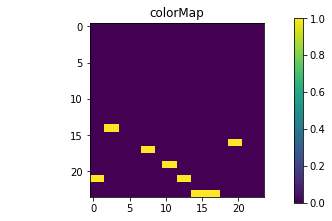

In [20]:
#print(bar_list[0][0],bar_matrix_list[0][0],bar_matrix_list2[0][0]) 큰 의미 없다
import numpy as np
import matplotlib.pyplot as plt

H = bar_matrix_list3[0][0]

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

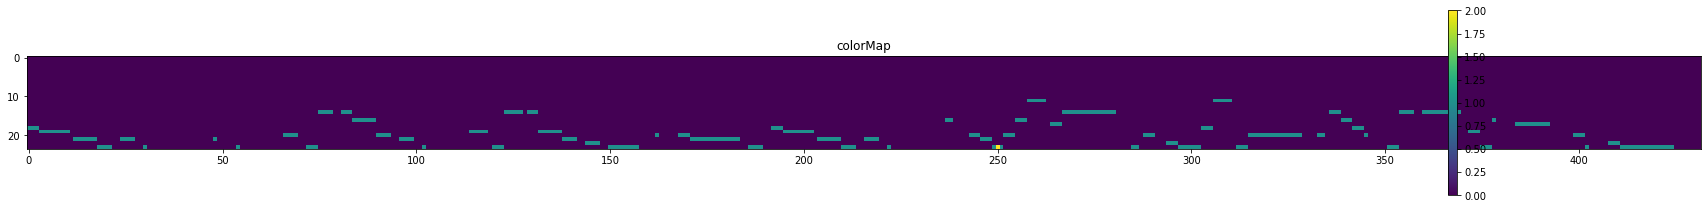

In [21]:
tot=bar_matrix_list3[2]
H=bar_matrix_list3[2][0]
for i in range(1,len(tot)):
  a=bar_matrix_list3[2][i]
  H=np.concatenate((H,a),axis=1)
  
fig = plt.figure(figsize=(30, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
#위 for문 없이 돌리면 1 bar만 나옴

In [22]:
def bar_to_contour(bar,one_bar_number,starting_number,j):
  contour=[]
  pitch_change_list=[]
  duration_list=[]
  real_pitch_list=[]
  real_time_list=[]
  real_duration_list=[]
  now_pitch=1000
  first_time=starting_number+one_bar_number*j
  a=0
  for lists in bar:
    if(a!=0): 
      real_time_list.append(lists[0]-now_rhythm)
    now_rhythm=lists[0]
    a+=1
    if (first_time*1.001<lists[0]):#smoothing for case like first time=5.00001, lists[0]=5.0000..
      resting_time=lists[0]-first_time
      duration_list.append(resting_time)
      first_time=lists[0]
      pitch_change_list.append('Rest')
    if (now_pitch==1000):
      pitch_change_list.append('Starting_Point')
      real_pitch_list.append('Starting_Point')
      real_duration_list.append(lists[3])
      duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      a+=1
    else:
      pitch_change=lists[1]-now_pitch
      pitch_change_list.append(str(pitch_change))#나중에 int로 바꿔쓸 것. 자료형 터지는거 때문에 우선 스트링.
      duration_list.append(lists[3])
      real_duration_list.append(lists[3])
      first_time=first_time+lists[3]
      now_pitch=lists[1]
      real_pitch_list.append(str(pitch_change))
  if (first_time*1.001<starting_number+one_bar_number*(j+1)):
    pitch_change_list.append('Rest')#마지막 Rest
    duration_list.append(starting_number+one_bar_number*(j+1)-first_time)
  if(len(bar)!=0):
    real_time_list.append(starting_number+one_bar_number*(j+1)-now_rhythm)
  contour.append(pitch_change_list)
  contour.append(duration_list)
  contour.append(real_pitch_list)
  contour.append(real_time_list)
  contour.append(real_duration_list)
  #something
  return contour



Plot에서 중요한것은 Y-Axis의 0~112의 숫자가 Note의 반대 성향을 가진다는 것이다.(숫자가 커질수록 Note의 높이가 낮아진다.) 이는 PianoRoll을 이미지 처럼 사용하는 과정에서, 직관적인 학습이 가능하도록 이와 같이 구현한 것이다.

In [23]:
bar_contour_list=copy.deepcopy(bar_list)
for i,songs in enumerate(bar_list):
  for j,bar in enumerate(songs):
    contour=bar_to_contour(bar,one_bar_number_list[i],starting_number_list[i],j)
    bar_contour_list[i][j]=contour


bar_contour_list : 중간과정
bar_matrix_list2 : 아마 학습에 사용하게 될 Matrix의 List
bar_label_list : 학습에 사용하게 될 Label의 List

In [24]:
print(bar_contour_list[0][0])


[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5]]


In [25]:
for contours in bar_contour_list[11]:
  print(contours)
print(jsonlist[11])

[['Starting_Point', 'Rest', '-8.0', '3.0', 'Rest', '5.0', 'Rest'], [0.3333333333333333, 0.16666666666666669, 0.25, 0.16666666666666663, 0.08333333333333337, 0.33333333333333326, 2.666666666666667], ['Starting_Point', '-8.0', '3.0', '5.0'], [0.5, 0.25, 0.25, 3.0], [0.3333333333333333, 0.25, 0.16666666666666663, 0.33333333333333326]]
[['Rest', 'Starting_Point', '1.0'], [3.5, 0.25, 0.33333333333333215], ['Starting_Point', '1.0'], [0.25, 0.25], [0.25, 0.33333333333333215]]
[['Starting_Point', 'Rest'], [0.25, 3.75], ['Starting_Point'], [4.0], [0.25]]
[['Rest'], [4.0], [], [], []]
[['Starting_Point', '-9.0', '1.0', '8.0', '-12.0', 'Rest'], [0.25, 0.25, 0.33333333333333215, 0.25, 0.33333333333333215, 2.5833333333333357], ['Starting_Point', '-9.0', '1.0', '8.0', '-12.0'], [0.25, 0.25, 0.25, 0.25, 3.0], [0.25, 0.25, 0.33333333333333215, 0.25, 0.33333333333333215]]
[['Rest'], [4.0], [], [], []]
[['Starting_Point', '-9.0', '1.0', '3.0', 'Rest', '5.0', 'Rest'], [0.25, 0.25, 0.25, 0.166666666666664

In [26]:
#최대한 많고 깔끔한 조건문을 사용하여 Skill들을 정의해볼 것. Multilabel Classification의 가능성이 있다.
"""
Skill들의 음악학적인 특성 & 계산적인 특성을 적는 곳
'resting' : 포함하는 음이 0 또는 1개인 경우 resting으로 정의. 다른 Skill들은 겹칠 수 있으나 이 skill이 Label될 경우 그냥 resting 고정이다.
즉, Skilling Labeling은 'resting'이 아닌 경우에 진행된다.
'repeating' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 전부 같은 음일 경우 repeating으로 정의
'up_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping up 또는 같은 음, 즉 반음기준 3Note 이하로 상승하는 형태일 경우 up_steping으로 정의
'down_steping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 steping down 또는 같은 음, 즉 반음기준 3Note 이하로 하강하는 형태일 경우 down_steping으로 정의
'up_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping up, 즉 반음기준 3Note 이상으로 상승하는 형태일 경우 up_leaping으로 정의
'down_leaping' : 전체 음 중 n% 이상 또는 n개를 제외한 경우가 leaping down, 즉 반음기준 3Note 이상으로 하강하는 형태일 경우 down_leaping으로 정의
3Note에서 겹치는게 맞다. Multilabel Classification을 고안 중이기 때문.
'steping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 2Note 이하의 상승과 하강을 반복하는 형태일 경우 steping_twisting으로 정의
'leaping_twisting' : 음이 4개 이상이고, n개를 제외한 경우가 3Note 이상의 상승과 하강을 반복하는 형태일 경우 leaping_twisting으로 정의
'fast_rhythm' : 1 bar 내에 음이 9개 이상인 경우 fast_rhythm으로 정의.
'One_rhythm' :  모든 음이 지닌 연주의 real_time, 즉 음이 울리고 다음 음이 나올때 까지의 시간이 같으면 One_rhythm으로 정의
'triplet' : real_time기반해서 triplet이 존재하면(Note 3개) triplet으로 정의
'Staccato' : real_Duration_Time 기반해서 n% 이상의 음의 Duration이 0.16667(최소단위*4임)보다 작으면(매우 짧으면) Staccato로 정의
'continuing_rhythm' : pitch_change_list에서 'Rest'의 비율이 25퍼센트 이하면 continuing_rhythm으로 정의
첫 음 제외 실 음의 75%를 기준으로 잡는다.
5개 이상의 음이 있다면 1개를 제외하고 전부 조건에 맞아야하고,
9개 이상의 음이 있다면 2개를 제외하고 전부 조건에 맞아야하고...
4개 이하는 다 맞아야 한다.
ex) CDEF -> up_steping, CDED -> None, CDEFD-> up_steping.
다만 Leaping에 대해서는 많이 후해질 것 같다. 거의 50%가까이..?  
"""

"""
예시로는..
contour[0] = ['Starting_Point', 'Rest', '4.0', '1.0', 'Rest', '2.0', 'Rest', '-7.0', 'Rest'] Note pitch의 변화를 쉼표를 포함하여 의미한다.
contour[1] = [0.83333, 0.16666999999999987, 0.5, 0.33333, 0.16666999999999987, 0.8333299999999999, 0.16666999999999987, 0.75, 0.25] Duration을 쉼표를 포함하여 의미한다.
contour[2] = ['Starting_Point', '4.0', '1.0', '2.0', '-7.0'] note pitch의 변화를 의미한다.
contour[3] = [1.0, 0.5, 0.5, 1.0, 1.0] 한 음의 실 연주시간을 의미한다.(다음 음이 나올때 까지의 시간)
contour[4] = [0.83333, 0.5, 0.33333, 0.8333299999999999, 0.75] Duration을 의미한다.
"""
def is_repeating(contour_list,exception_range):
  boolean_repeating=0
  non_repeat=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if(elements != '0.0'):
        non_repeat+=1
  if (non_repeat<=exception_range):
    boolean_repeating=1
  return boolean_repeating

def is_up_steping(contour_list,exception_range):
  balancing_param=1
  boolean_up_steping=0
  non_step_up=0
  now_step_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_up==0):
        if (float(elements)<0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
      else:
        if(float(elements)<-0.5 or float(elements)>4.5):
          now_step_up=0
          non_step_up+=1
        else:
          now_step_up=1
  if(non_step_up<=exception_range+balancing_param):
    boolean_up_steping=1
  return boolean_up_steping

def is_down_steping(contour_list,exception_range):
  boolean_down_steping=0
  balancing_param=0
  non_step_down=0
  now_step_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_step_down==0):
        if (float(elements)>-0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
      else:
        if(float(elements)>0.5 or float(elements)<-4.5):
          now_step_down=0
          non_step_down+=1
        else:
          now_step_down=1
  if(non_step_down<=exception_range+balancing_param):
    boolean_down_steping=1
  return boolean_down_steping

def is_up_leaping(contour_list,exception_range):
  boolean_up_leaping=0
  non_leap_up=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)<3.5):
        non_leap_up+=1
  if (non_leap_up<=exception_range+1):
    boolean_up_leaping=1
  return boolean_up_leaping

def is_down_leaping(contour_list,exception_range):
  boolean_down_leaping=0
  non_leap_down=0
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (float(elements)>-3.5):
        non_leap_down+=1
  if (non_leap_down<=exception_range+1):
    boolean_down_leaping=1
  return boolean_down_leaping

def is_leaping_twisting(contour_list,exception_range):
  boolean_leaping_twisting=0
  non_leap_twist=0
  balancing_param=1
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (3.5<float(elements)):
          now_dir=1
        elif (float(elements) <-3.5):
          now_dir=-1
        else:
          non_leap_twist+=1
      elif (now_dir==1):
        if (float(elements) <-3.5):
          now_dir=-1
        else:
          now_dir=0
          non_leap_twist+=1
      elif (now_dir==-1):
        if (3.5<float(elements)):
          now_dir=1
        else:
          now_dir=0
          non_leap_twist+=1
  if(non_leap_twist<=exception_range+balancing_param):
    boolean_leaping_twisting=1
  return boolean_leaping_twisting

def is_steping_twisting(contour_list,exception_range):
  boolean_steping_twisting=0
  non_step_twist=0
  now_dir=0 #1for up, -1 for down
  for elements in contour_list:
    if (elements is not 'Starting_Point'):
      if (now_dir==0):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        elif (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          non_step_twist+=1
      elif (now_dir==1):
        if (-2.5<float(elements) and float(elements) <0):
          now_dir=-1
        else:
          now_dir=0
          non_step_twist+=1
      elif (now_dir==-1):
        if (0<float(elements) and float(elements) <2.5):
          now_dir=1
        else:
          now_dir=0
          non_step_twist+=1
  if(non_step_twist<=exception_range):
    boolean_steping_twisting=1
  return boolean_steping_twisting

def is_one_rhythm(contour_list,exception_range):
  boolean_one_rhythm=0
  non_same_rhythm=0

  first_rhythm=contour_list[0]
  for rhythms in contour_list:
    if (rhythms != first_rhythm):
      non_same_rhythm=1
  boolean_one_rhythm=1-non_same_rhythm
  return boolean_one_rhythm

def is_triplet(contour_list,exception_range):
  boolean_triplet=0
  now_triplet=0
  for rhythms in contour_list:
    rhythms=float(rhythms)
    if (rhythms%0.015625>0.001):
      if(now_triplet==1):
        boolean_triplet=1
      now_triplet+=1
    else:
      now_triplet=0
      
  return boolean_triplet

def is_staccato(contour_list,exception_range):
  boolean_staccato=0
  ranges=len(contour_list)//2
  staccato_num=0
  for times in contour_list:
    if (times<0.2):
      staccato_num+=1
  if (staccato_num>=ranges):
    boolean_staccato=1
  return boolean_staccato

def is_continuing_rhythm(contour_list):
  boolean_continuing_rhythm=0
  length=len(contour_list)
  rest_num=0
  for elements in contour_list:
    if (elements=='Rest'):
      rest_num+=1
  if (rest_num<=0.5):
    boolean_continuing_rhythm=1
  return boolean_continuing_rhythm

def contour_to_label(contour):
  labels=[]
  totnum=len(contour[2]) #실 음의 갯수이다.
  exception_range=(totnum-1)//4
  exception_range2=(totnum-1)//3
  if (len(contour[2])<2.5):
    labels.append('resting')
    return labels
  else:
    if (is_repeating(contour[2],exception_range2)):
      labels.append('repeating')

    if (is_up_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('up_steping')

    if (is_down_steping(contour[2],exception_range)):
      if (len(contour[2])>3):
        labels.append('down_steping')

    if (is_up_leaping(contour[2],exception_range2)):
      labels.append('up_leaping')
    
    if (is_down_leaping(contour[2],exception_range2)):
      labels.append('down_leaping')

    if (is_steping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('steping_twisting')

    if (is_leaping_twisting(contour[2],exception_range2)):
      if (len(contour[2])>3):
        labels.append('leaping_twisting')

    if (len(contour[2])>8.5):
      labels.append('fast_rhythm')

    if (is_one_rhythm(contour[3],exception_range)):
      labels.append('One_rhythm')

    if (is_triplet(contour[3],exception_range2)):
      labels.append('triplet')

    if (is_staccato(contour[4],exception_range2)):
      labels.append('staccato')  

    if (is_continuing_rhythm(contour[0])):
      labels.append('continuing_rhythm')  

  """
  if (len(labels)==0):
    labels.append('no skills')
    meanless.
  """

  return labels

In [27]:
bar_label_list=copy.deepcopy(bar_contour_list)
for i,songs in enumerate(bar_contour_list):
  for j,contour in enumerate(songs):
    label=contour_to_label(contour) 
    bar_label_list[i][j]=label

In [28]:
for j in range(len(bar_label_list[0])):
  print(bar_label_list[0][j])
  print(bar_contour_list[0][j])

[]
[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5]]
[]
[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5]]
['repeating']
[['Starting_Point', '7.0', 'Rest', '-7.0', '0.0', '0.0', '0.0', '0.0'], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0], ['Starting_Point', '7.0', '-7.0', '0.0', '0.0', '0.0', '0.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0]]
['leaping_twisting', 'continuing_rhythm']
[['Starting_Point', '7.0', '-7.0', '4.0', '3.0', '3.0', '-5.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], ['Starting_Point', '7.0', '-7.0', '4.0', '3.0

[['Starting_Point', '7.0', 'Rest', '-3.0', '-2.0', '-2.0', '-2.0', '7.0', 'Rest'], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 0.5], ['Starting_Point', '7.0', '-3.0', '-2.0', '-2.0', '-2.0', '7.0'], [0.5, 1.0, 0.5, 0.5, 0.5, 1.0, 1.0], [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5]]
[]
[[ 0.  48.  48.   0.5  0. ]
 [ 0.5 55.  55.   0.5  0. ]
 [ 1.5 52.  52.   0.5  0. ]
 [ 2.  50.  50.   0.5  0. ]
 [ 2.5 48.  48.   0.5  0. ]
 [ 3.  46.  46.   1.   0. ]
 [ 4.  53.  53.   0.5  0. ]]


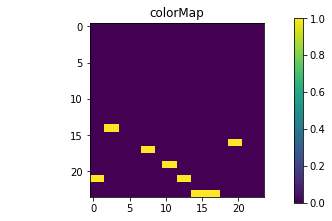

In [29]:
#Summary
print(bar_contour_list[0][0])
print(bar_label_list[0][0])
print(bar_list[0][0])

H=bar_matrix_list3[0][0]
fig = plt.figure(figsize=(6, 3.2))
ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()
#위 for문 없이 돌리면 1 bar만 나옴
#matrix_list2를 CNN하되 라벨을 label로 가져가면 될듯 bar_label_list[i][j]는 i번째곡의 j번째 bar를 의미하고, 나머지도 같다.

In [30]:
all_matrix=[]
all_labels=[]
all_updown_labels=[]
for songs in bar_label_list:
  for label in songs:
    label=np.array(label)
    all_labels.append(label)
bar_label_list=[]#램 터짐
for songs in bar_matrix_list3:
  for matrix in songs:
    matrix=matrix.reshape(24,24,1)
    all_matrix.append(matrix)
for songs in bar_updown_list:
  for label in songs:
    all_updown_labels.append(label)


In [31]:
print(len(all_matrix),len(all_labels),len(all_updown_labels))

175857 175857 175857


In [32]:
import keras.backend.tensorflow_backend as tfback
from tensorflow.python.client import device_lib
def _get_available_gpus():
  if tfback._LOCAL_DEVICES is None:
    devices = device_lib.list_local_devices()
    tfback._LOCAL_DEVICES = [x.name for x in devices]
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer
train_matrix=np.array(all_matrix[:150000])
train_label=np.array(all_labels[:150000])

In [34]:
def set_labels():
  labels=[]
  label_tuple=[]
  skills_pitch=['repeating','up_steping','down_steping','up_leaping','down_leaping','steping_twisting','leaping_twisting','dummy']
  skills_timing=['resting','fast_rhythm','dummy']
  skills_triplet=['triplet','dummy']
  skills_one_rhythm=['One_rhythm','dummy']
  skills_staccato=['staccato','continuing_rhythm','dummy']
  for pitch in skills_pitch:
    for timing in skills_timing:
      for triplet in skills_triplet:
        for one_rhythm in skills_one_rhythm:
          for staccato in skills_staccato:
            label_tuple=[]
            if pitch is not 'dummy':
              label_tuple.append(pitch)
            if timing is not 'dummy':
              label_tuple.append(timing)
            if triplet is not 'dummy':
              label_tuple.append(triplet)
            if one_rhythm is not 'dummy':
              label_tuple.append(one_rhythm)
            if staccato is not 'dummy':
              label_tuple.append(staccato)
            label_tuple=tuple(label_tuple)
            labels.append(label_tuple)
  return labels

In [35]:
label=set_labels()
print(label)

[('repeating', 'resting', 'triplet', 'One_rhythm', 'staccato'), ('repeating', 'resting', 'triplet', 'One_rhythm', 'continuing_rhythm'), ('repeating', 'resting', 'triplet', 'One_rhythm'), ('repeating', 'resting', 'triplet', 'staccato'), ('repeating', 'resting', 'triplet', 'continuing_rhythm'), ('repeating', 'resting', 'triplet'), ('repeating', 'resting', 'One_rhythm', 'staccato'), ('repeating', 'resting', 'One_rhythm', 'continuing_rhythm'), ('repeating', 'resting', 'One_rhythm'), ('repeating', 'resting', 'staccato'), ('repeating', 'resting', 'continuing_rhythm'), ('repeating', 'resting'), ('repeating', 'fast_rhythm', 'triplet', 'One_rhythm', 'staccato'), ('repeating', 'fast_rhythm', 'triplet', 'One_rhythm', 'continuing_rhythm'), ('repeating', 'fast_rhythm', 'triplet', 'One_rhythm'), ('repeating', 'fast_rhythm', 'triplet', 'staccato'), ('repeating', 'fast_rhythm', 'triplet', 'continuing_rhythm'), ('repeating', 'fast_rhythm', 'triplet'), ('repeating', 'fast_rhythm', 'One_rhythm', 'staccat

In [36]:
valid_matrix=np.array(all_matrix[150000:170000])
valid_label=np.array(all_labels[150000:170000])
test_matrix=np.array(all_matrix[170000:])
test_label=np.array(all_labels[170000:])#어쩌면 쓸수도?
mlb=MultiLabelBinarizer()
labels=set_labels()
mlb.fit(labels)
train_label2=mlb.transform(train_label)
valid_label2=mlb.transform(valid_label)
test_label2=mlb.transform(test_label)


In [82]:
print(train_label2.shape)

(150000, 13)


In [85]:
from sklearn.preprocessing import LabelBinarizer
updownle=LabelBinarizer()
updownle.fit(['up','down','final','meanless'])
updown_label=updownle.transform(np.array(all_updown_labels))

In [87]:
train_updown_label=updown_label[:150000]
valid_updown_label=updown_label[150000:170000]
test_updown_label=updown_label[170000:]

In [39]:
all_matrix=[]
all_labels=[]

In [40]:
print(train_matrix.shape)
print(train_label2)
print(valid_matrix.shape)

(150000, 24, 24, 1)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(20000, 24, 24, 1)


In [68]:
import keras.applications
from keras import regularizers
from keras.applications import VGG16
from keras.applications import resnet50
from keras import layers
from tensorflow import keras
def residual_block(filter, input, add=True):
  with tf.device('/gpu:0'):
    layer_1 = keras.layers.Conv2D(filters=filter//4, kernel_size=(1, 1), data_format="channels_first")(input)
    layer_2 = keras.layers.Conv2D(filters=filter//4, kernel_size=(3, 3), padding='same', data_format="channels_first", kernel_regularizer=keras.regularizers.l2(0.001))(layer_1)
    layer_2 = keras.layers.BatchNormalization()(layer_2)
    layer_2 = keras.layers.ReLU()(layer_2)
    layer_3 = keras.layers.Conv2D(filters=filter, kernel_size=(1, 1), data_format="channels_first")(layer_2)
    layer_3 = keras.layers.BatchNormalization()(layer_3)
    if add:
        layer_3 = keras.layers.add([input, layer_3])
    layer_3 = keras.layers.ReLU()(layer_3)
    return layer_3
def make_model():
  with tf.device('/gpu:0'):
    input_layer = keras.Input(shape=(24, 24, 1))
    layer_1 = keras.layers.Conv2D(filters=64, kernel_size=(7, 7), padding='same', data_format="channels_first")(input_layer)
    block_1 = residual_block(64, layer_1)
    #block_2 = residual_block(64, block_1)
    #block_3 = residual_block(64, block_2)
    pooling_layer = keras.layers.MaxPool2D((2, 2),padding='same', data_format="channels_first")(block_1)
    block_4 = residual_block(128, pooling_layer, add=False)
    block_5 = residual_block(128, block_4)
    #block_6 = residual_block(128, block_5)
    pooling_layer2 = keras.layers.MaxPool2D(padding='same',pool_size=(2, 2), data_format="channels_first")(block_4)
    block_7 = residual_block(256, pooling_layer2, add=False)
    block_8 = residual_block(256, block_7)
    block_9 = residual_block(256, block_8)
    #pooling_layer4 = keras.layers.MaxPool2D(pool_size=(2, 2), data_format="channels_first")(block_7)
    #block_10 = residual_block(256, pooling_layer4)
    #block_11 = residual_block(512, block_10)
    pooling_layer3 = keras.layers.AvgPool2D(padding='same',pool_size=(8, 8), data_format="channels_first")(block_7)
    last_layer = keras.layers.Flatten()(pooling_layer3)
    last_layer = keras.layers.Dropout(0.4)(last_layer)
    last_layer = keras.layers.Dense(13, activation="sigmoid")(last_layer)
    return keras.models.Model(inputs=input_layer, outputs=last_layer)
def make_classifier():
  with tf.device('/gpu:0'):
    classifier = keras.Sequential()
    classifier.add(keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same',
                  activation='relu',
                  input_shape=(24,24,1)))
    classifier.add(keras.layers.BatchNormalization())
    classifier.add(keras.layers.LeakyReLU(alpha=0.01))
    classifier.add(keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    classifier.add(keras.layers.Conv2D(256, (2, 2), padding='same'))
    classifier.add(keras.layers.LeakyReLU(alpha=0.01))
    classifier.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    classifier.add(keras.layers.Flatten())
    classifier.add(keras.layers.Dropout(0.25))
    classifier.add(keras.layers.Dense(4, activation='sigmoid'))
  return classifier

In [91]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_path = '/content/drive/My Drive/models/' + 'deeperppddbest.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)
callbacks = [cb_checkpoint]

model_path = '/content/drive/My Drive/models/' + 'updown.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                                verbose=1, save_best_only=True)
updown_callbacks=[cb_checkpoint]
#tf.keras의 경우(make_model) monitor='val_acc'로, keras의 경우(make_classifier) monitor='val_accuracy'로 해야한다.

In [43]:
from keras import backend as K
import tensorflow as tf
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


In [62]:
from tensorflow import keras
classifier=make_model()
classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='binary_crossentropy'
  ), optimizer='adam', metrics=['accuracy',recall,precision,f1score])
"""
hist=classifier.fit(
      train_matrix,train_label2,batch_size=256,
      epochs=150,
      validation_data=(valid_matrix,valid_label2),
      callbacks=callbacks,
  )
"""

#실제 학습


'\nhist=classifier.fit(\n      train_matrix,train_label2,batch_size=256,\n      epochs=150,\n      validation_data=(valid_matrix,valid_label2),\n      callbacks=callbacks,\n  )\n'

In [94]:
#음의 흐름에 관한 분류기
updown_classifier=make_classifier()
updown_classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False,
      name='binary_crossentorpy'
  ), optimizer='adam', metrics=['accuracy'])
updown_hist=updown_classifier.fit(
      train_matrix,train_updown_label,batch_size=256,
      epochs=150,
      validation_data=(valid_matrix,valid_updown_label),
      callbacks=updown_callbacks,
  )


Train on 150000 samples, validate on 20000 samples
Epoch 1/150
149760/150000 [============================>.] - ETA: 0s - loss: 0.3370 - acc: 0.8364
Epoch 00001: val_acc did not improve from 0.84052
150000/150000 [==============================] - 20s 131us/sample - loss: 0.3370 - acc: 0.8364 - val_loss: 0.3756 - val_acc: 0.8274
Epoch 2/150
149760/150000 [============================>.] - ETA: 0s - loss: 0.3234 - acc: 0.8463
Epoch 00002: val_acc did not improve from 0.84052
150000/150000 [==============================] - 19s 126us/sample - loss: 0.3234 - acc: 0.8464 - val_loss: 0.3391 - val_acc: 0.8352
Epoch 3/150
149760/150000 [============================>.] - ETA: 0s - loss: 0.3176 - acc: 0.8506
Epoch 00003: val_acc did not improve from 0.84052
150000/150000 [==============================] - 19s 126us/sample - loss: 0.3175 - acc: 0.8506 - val_loss: 0.3406 - val_acc: 0.8369
Epoch 4/150
149760/150000 [============================>.] - ETA: 0s - loss: 0.3129 - acc: 0.8538
Epoch 00004

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, recall_ax = plt.subplots()


recall_ax.plot(hist.history['recall'], 'y', label='recall')
recall_ax.plot(hist.history['val_recall'], 'r', label='valid recall')

recall_ax.plot(hist.history['f1score'], 'b', label='f1score')
recall_ax.plot(hist.history['val_f1score'], 'g', label='valid f1score')

recall_ax.plot(hist.history['precision'], 'c', label='precision')
recall_ax.plot(hist.history['val_precision'], 'k', label='valid precision')

recall_ax.set_xlabel('epoch')
recall_ax.set_ylabel('score')

recall_ax.legend(loc='upper left')

plt.show()

In [96]:
  classifier.load_weights("/content/drive/My Drive/models/deeperppddbest.h5")
  testresult=classifier.predict(test_matrix)

In [97]:
print(testresult)

[[0.0520255  0.04725242 0.06422505 ... 0.22541031 0.13303784 0.08977461]
 [0.8743255  0.0428139  0.05168912 ... 0.08904213 0.07070249 0.04728562]
 [0.06394652 0.04105222 0.04254055 ... 0.14287636 0.07774505 0.04171047]
 ...
 [0.91817886 0.9472953  0.04020622 ... 0.03975582 0.15174589 0.03289729]
 [0.89631355 0.9194241  0.05759662 ... 0.06776044 0.37178284 0.0566242 ]
 [0.03227803 0.15996751 0.03780636 ... 0.13953447 0.61530125 0.05385279]]


In [98]:
def get_tag_results(testresult,test_label2):  
  classnum={}
  testnum={}
  resultmat=[]
  bestmat=[]
  for i in range(len(testresult)):
    eval_result=[0 for i in range(13)]
    best_result=[0 for i in range(13)]
    class_num=np.count_nonzero(test_label2[i]==1)+1
    classidx=(-testresult[i]).argsort()[:class_num]
    for k,j in enumerate(classidx):
      if (k==0):
        best_result[j]=1
      eval_result[j]=1
    resultmat.append(eval_result)
    bestmat.append(best_result)
    test_result2=copy.deepcopy(testresult)
    test_result2[np.where(test_result2>0.30)]=1
    test_result2[np.where(test_result2<=0.30)]=0
  resultmat=np.array(resultmat)
  bestmat=np.array(bestmat)
  testidx=mlb.inverse_transform(resultmat)
  classidx=mlb.inverse_transform(test_label2)
  testidx2=mlb.inverse_transform(test_result2)
  bestidx=mlb.inverse_transform(bestmat)
  for i in range(len(testidx)):  
    #print(bestidx[i],testidx2[i],testidx[i], classidx[i],i) # 값이 0.30 이상인 set, 원래 Label보다 1개 많이 보여주는 내림차순 set, 원래 label set 순서이다. 
    for classes in classidx[i]:
      if (classes not in classnum):
        classnum[classes]=1
      else:
        classnum[classes]+=1
    for classes in testidx[i]:
      if (classes not in testnum):
        testnum[classes]=1
      else:
        testnum[classes]+=1
  print(classnum, testnum)
  return bestidx, testidx2, testidx, classidx#가장 높은거, 0.30이상인 set, 원래의 Label보다 1개 많이 보여주는 내림차순, 원래 Label
"""
best=get_tag_results(testresult,test_label2)[0]
print(best)
"""

'\nbest=get_tag_results(testresult,test_label2)[0]\nprint(best)\n'

In [ ]:
H = test_matrix[700].reshape(24,24) #위에 출력에서 나온 숫자 test_matrix['요기']에 적고 출력하면 나옴
fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

여기부터 GAN의 구현을 해봅니다. 

In [ ]:
!pip install -q imageio

In [99]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [100]:
def get_best_results(testresult,test_label2):  #for optimizing.
  classnum={}
  testnum={}
  resultmat=[]
  bestmat=[]
  for i in range(len(testresult)):
    best_result=[0 for i in range(13)]
    class_num=np.count_nonzero(test_label2[i]==1)+1
    classidx=(-testresult[i]).argsort()[:class_num]
    for k,j in enumerate(classidx):
      if (k==0):
        best_result[j]=1
    bestmat.append(best_result)
  bestmat=np.array(bestmat)
  bestidx=mlb.inverse_transform(bestmat)
  return bestidx

In [101]:
trainX=train_matrix.reshape((150000,24,24))
for i in tqdm(range(150),position=0):
  if(i==0):
    test_result=classifier.predict(train_matrix[1000*i:1000+1000*i])
  else:
    sub_testresult=classifier.predict(train_matrix[1000*i:1000+1000*i])
    test_result=np.concatenate((test_result,sub_testresult))
trainy=np.array(get_best_results(test_result,train_label2)).reshape((150000,))
print('Train', trainX.shape, trainy.shape)

100%|██████████| 150/150 [00:09<00:00, 16.39it/s]


Train (150000, 24, 24) (150000,)


In [102]:
from sklearn.preprocessing import LabelEncoder
# 라벨 인코더 생성
encoder = LabelEncoder()

# X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
encoder.fit(trainy)
trainy = encoder.transform(trainy)
print(trainy)
trainy=np.array(trainy)

[3 3 5 ... 7 0 8]


In [103]:
import numpy as np
import scipy as sp
import scipy.ndimage
def blur_image(matrix):
  sigma_y = 1.0
  sigma_x = 1.0
  inputmat=matrix
  """
  # Plot input array
  plt.imshow(inputmat, cmap='Blues', interpolation='nearest')
  plt.xlabel("$x$")
  plt.ylabel("$y$")
  plt.savefig("array.png")
  """
  # Apply gaussian filter
  sigma = [sigma_y, sigma_x]
  y = sp.ndimage.filters.gaussian_filter(inputmat, sigma, mode='constant')
  """
  # Display filtered array
  plt.imshow(y, cmap='Blues', interpolation='nearest')
  plt.xlabel("$x$")
  plt.ylabel("$y$")
  plt.title("$\sigma_x = " + str(sigma_x) + "\quad \sigma_y = " + str(sigma_y) + "$")
  plt.savefig("smooth_array_" + str(sigma_x) + "_" + str(sigma_y) + ".png")
  """
  return y


In [104]:
blur_trainX=copy.deepcopy(trainX)
for i,matrix in enumerate(trainX):
  blur_trainX[i]=blur_image(matrix)
trainX=blur_trainX

In [105]:
#https://github.com/gaborvecsei/CDCGAN-Keras/tree/master/cdcgan
#위 깃헙의 코드를 사용하는겁니다
import matplotlib

matplotlib.use('Agg')
from keras import models, layers

ACTIVATION = layers.Activation("tanh")


def generator_model():
  with tf.device('/gpu:0'):
    # Prepare noise input
    input_z = layers.Input((13,))
    dense_z_1 = layers.Dense(1024)(input_z)
    act_z_1 = ACTIVATION(dense_z_1)
    dense_z_2 = layers.Dense(128 * 6* 6)(act_z_1)
    bn_z_1 = layers.BatchNormalization()(dense_z_2)
    reshape_z = layers.Reshape((6, 6, 128), input_shape=(128 * 6 * 6,))(bn_z_1)

    # Prepare Conditional (label) input
    input_c = layers.Input((13,))
    dense_c_1 = layers.Dense(1024)(input_c)
    act_c_1 = ACTIVATION(dense_c_1)
    dense_c_2 = layers.Dense(128 * 6 * 6)(act_c_1)
    bn_c_1 = layers.BatchNormalization()(dense_c_2)
    reshape_c = layers.Reshape((6, 6, 128), input_shape=(128 * 6 * 6,))(bn_c_1)

    # Combine input source
    concat_z_c = layers.Concatenate()([reshape_z, reshape_c])

    # Image generation with the concatenated inputs
    up_1 = layers.UpSampling2D(size=(2, 2))(concat_z_c)
    conv_1 = layers.Conv2D(64, (5, 5), padding='same')(up_1)
    act_1 = ACTIVATION(conv_1)
    up_2 = layers.UpSampling2D(size=(2, 2))(act_1)
    conv_2 = layers.Conv2D(1, (5, 5), padding='same')(up_2)
    act_2 = layers.Activation("tanh")(conv_2)
    model = models.Model(inputs=[input_z, input_c], outputs=act_2)
    return model


def discriminator_model():
  with tf.device('/gpu:0'):
    input_gen_image = layers.Input((24, 24, 1))
    conv_1_image = layers.Conv2D(64, (5, 5), padding='same')(input_gen_image)
    act_1_image = ACTIVATION(conv_1_image)
    pool_1_image = layers.MaxPooling2D(pool_size=(2, 2))(act_1_image)
    conv_2_image = layers.Conv2D(128, (5, 5))(pool_1_image)
    act_2_image = ACTIVATION(conv_2_image)
    pool_2_image = layers.MaxPooling2D(pool_size=(2, 2))(act_2_image)

    input_c = layers.Input((13,))
    dense_1_c = layers.Dense(1024)(input_c)
    act_1_c = ACTIVATION(dense_1_c)
    dense_2_c = layers.Dense(4 * 4 * 128)(act_1_c)
    bn_c = layers.BatchNormalization()(dense_2_c)
    reshaped_c = layers.Reshape((4, 4, 128))(bn_c)

    concat = layers.Concatenate()([pool_2_image, reshaped_c])

    flat = layers.Flatten()(concat)
    dense_1 = layers.Dense(1024)(flat)
    act_1 = ACTIVATION(dense_1)
    dense_2 = layers.Dense(1)(act_1)
    act_2 = layers.Activation('sigmoid')(dense_2)
    model = models.Model(inputs=[input_gen_image, input_c], outputs=act_2)
    return model


def generator_containing_discriminator(g, d):
  with tf.device('/gpu:0'):
    input_z = layers.Input((13,))
    input_c = layers.Input((13,))
    gen_image = g([input_z, input_c])
    d.trainable = False
    is_real = d([gen_image, input_c])
    model = models.Model(inputs=[input_z, input_c], outputs=is_real)
    return model

In [128]:
import math
import os
import subprocess

import cv2
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np


def combine_images(generated_images):
    num_images = generated_images.shape[0]
    new_width = int(math.sqrt(num_images))
    new_height = int(math.ceil(float(num_images) / new_width))
    grid_shape = generated_images.shape[1:3]
    grid_image = np.zeros((new_height * grid_shape[0], new_width * grid_shape[1]), dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index / new_width)
        j = index % new_width
        grid_image[i * grid_shape[0]:(i + 1) * grid_shape[0], j * grid_shape[1]:(j + 1) * grid_shape[1]] = \
            img[:, :, 0]
    return grid_image


def generate_noise(shape: tuple):
    noise = np.random.uniform(0, 1, size=shape)
    return noise


def generate_condition_embedding(label: int, nb_of_label_embeddings: int):
    label_embeddings = np.zeros((nb_of_label_embeddings, 13))
    label_embeddings[:, label] = 1
    return label_embeddings


def generate_images(generator, nb_images: int, label: int):
    noise = generate_noise((nb_images, 13))
    label_batch = generate_condition_embedding(label, nb_images)
    generated_images = generator.predict([noise, label_batch], verbose=0)
    return generated_images


def generate_mnist_image_grid(generator, title: str = "Generated images"):
    generated_images = []

    for i in range(10):
        noise = generate_noise((10, 13))
        label_input = generate_condition_embedding(i, 10)
        gen_images = generator.predict([noise, label_input], verbose=0)
        generated_images.extend(gen_images)

    generated_images = np.array(generated_images)
    image_grid = combine_images(generated_images)
    image_grid = inverse_transform_images(image_grid)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(image_grid, cmap="gray")
    ax.set_title(title)
    fig.canvas.draw()

    image = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    plt.close()

    return image


def save_generated_image(image, epoch, iteration, folder_path):
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)

    file_path = "{0}/{1}_{2}.png".format(folder_path, epoch, iteration)
    cv2.imwrite(file_path, image.astype(np.uint8))


def transform_images(images: np.ndarray):
    """
    [0,1]Transform images to [-1, 1]
    """
    max_value=images.max()

    images = (images.astype(np.float32) - (max_value/2)) / (max_value/2)
    return images


def inverse_transform_images(images: np.ndarray):
    """
    From the [-1, 1] range transform the images back to [0, 255]
    """

    images = images * 127.5 + 127.5
    images = images.astype(np.uint8)
    return images


def convert_video_to_gif(input_video_path, output_gif_path, fps=24):
    palette_image_path = "palette.png"
    command_palette = 'ffmpeg -y -t 0 -i {0} -vf fps={1},scale=320:-1:flags=lanczos,palettegen {2}'.format(input_video_path,
                                                                                                           fps,
                                                                                                           palette_image_path)
    command_convert = 'ffmpeg -y -t 0 -i {0} -i {1} -filter_complex "fps={2},scale=320:-1:flags=lanczos[x];[x][1:v]paletteuse" {3}'.format(input_video_path,palette_image_path, fps, output_gif_path)
    
    try:
        subprocess.check_call(command_palette)
        subprocess.check_call(command_convert)
    except subprocess.CalledProcessError as exc:
        print(exc.output)
        raise
    finally:
        os.remove(palette_image_path)

In [107]:
pip install git+https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git

  Cloning https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git to /tmp/pip-req-build-op2wvc9z
  Running command git clone -q https://github.com/gaborvecsei/Swiss-Army-Tensorboard.git /tmp/pip-req-build-op2wvc9z
  Created wheel for swiss-army-tensorboard: filename=swiss_army_tensorboard-0.0.1-cp36-none-any.whl size=5377 sha256=c0a3bed04084716092b3f5bd86204d7d393774957d4f275d05c06816e6896715
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhnuokk_/wheels/ea/f7/db/67f8661f9c334ad8eda2d0dfbc21bcaea99f739c97f6008d41
Successfully built swiss-army-tensorboard


In [129]:
import matplotlib

matplotlib.use('Agg')
import numpy as np
from keras import backend as K
from keras import utils as keras_utils
from keras import optimizers
from keras import datasets
from swiss_army_tensorboard import tfboard_loggers
from tqdm import tqdm
#from cdcgan import cdcgan_models, cdcgan_utils
#colab환경이라 안씁니다

BATCH_SIZE = 128
EPOCHS = 100

# Load & Prepare MNIST

X_train=trainX
y_train=trainy
X_train = transform_images(X_train)
X_train = X_train[:, :, :, None]

y_train = keras_utils.to_categorical(y_train, 13) #원래는 13써야 하는데 추후 고려할 예정

# Create the models

print("Generator:")
G = generator_model()
G.summary()

print("Discriminator:")
D = discriminator_model()
D.summary()

print("Combined:")
GD = generator_containing_discriminator(G, D)
GD.summary()

optimizer = optimizers.Adam(0.0002, 0.5)


G.compile(loss='binary_crossentropy', optimizer=optimizer)
GD.compile(loss='binary_crossentropy', optimizer=optimizer)
D.trainable = True
D.compile(loss='binary_crossentropy', optimizer=optimizer)

Generator:
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           (None, 13)           0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 1024)         14336       input_30[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 1024)         14336       input_31[0][0]                   
________________________________________________________________________________

In [109]:
G.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")
D.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/discriminator.h5")

In [130]:
# Setup Tensorboard loggers

tfboard_loggers.TFBoardModelGraphLogger.log_graph("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs", K.get_session())
loss_logger = tfboard_loggers.TFBoardScalarLogger("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/loss")
image_logger = tfboard_loggers.TFBoardImageLogger("/content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/generated_images")

# Model Training

iteration = 0

nb_of_iterations_per_epoch = int(X_train.shape[0] / BATCH_SIZE)
print("Number of iterations per epoch: {0}".format(nb_of_iterations_per_epoch))

for epoch in range(EPOCHS):
    pbar = tqdm(desc="Epoch: {0}".format(epoch), total=X_train.shape[0],position=0)

    g_losses_for_epoch = []
    d_losses_for_epoch = []

    for i in range(nb_of_iterations_per_epoch):
        noise = generate_noise((BATCH_SIZE, 13))

        image_batch = X_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        label_batch = y_train[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]

        generated_images = G.predict([noise, label_batch], verbose=0)

        if i % 20 == 0:
            image_grid = generate_mnist_image_grid(G,
                                                                title="Epoch {0}, iteration {1}".format(epoch,
                                                                                                        iteration))
            save_generated_image(image_grid, epoch, i, "/content/drive/My Drive/MARG/PPDDlist/GAN_result/generated_mnist_images_per_iteration")
            image_logger.log_images("generated_mnist_images_per_iteration", [image_grid], iteration)

        X = np.concatenate((image_batch, generated_images))
        y = [1] * BATCH_SIZE + [0] * BATCH_SIZE
        label_batches_for_discriminator = np.concatenate((label_batch, label_batch))

        D_loss = D.train_on_batch([X, label_batches_for_discriminator], y)
        d_losses_for_epoch.append(D_loss)
        loss_logger.log_scalar("discriminator_loss", D_loss, iteration)

        noise = generate_noise((BATCH_SIZE, 13))
        D.trainable = False
        G_loss = GD.train_on_batch([noise, label_batch], [1] * BATCH_SIZE)
        D.trainable = True
        g_losses_for_epoch.append(G_loss)
        loss_logger.log_scalar("generator_loss", G_loss, iteration)

        pbar.update(BATCH_SIZE)

        iteration += 1

    # Save a generated image for every epoch
    image_grid = generate_mnist_image_grid(G, title="Epoch {0}".format(epoch))
    save_generated_image(image_grid, epoch, 0, "/content/drive/My Drive/MARG/PPDDlist/GAN_result/generated_mnist_images_per_epoch")
    image_logger.log_images("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generated_mnist_images_per_epoch", [image_grid], epoch)

    pbar.close()
    print("D loss: {0}, G loss: {1}".format(np.mean(d_losses_for_epoch), np.mean(g_losses_for_epoch)))

    G.save_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")
    D.save_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/discriminator.h5")

/usr/local/lib/python3.6/dist-packages/swiss_army_tensorboard/tfboard_loggers/tfboard_loggers.py:19: UserWarning: Folder /content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/loss is already created, maybe it contains other log files
  warnings.warn("Folder {0} is already created, maybe it contains other log files".format(log_dir))
/usr/local/lib/python3.6/dist-packages/swiss_army_tensorboard/tfboard_loggers/tfboard_loggers.py:19: UserWarning: Folder /content/drive/My Drive/MARG/PPDDlist/GAN_result/logs/generated_images is already created, maybe it contains other log files
  warnings.warn("Folder {0} is already created, maybe it contains other log files".format(log_dir))
Epoch: 0:   0%|          | 0/150000 [00:00<?, ?it/s]

Number of iterations per epoch: 1171


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
Epoch: 0: 100%|█████████▉| 149888/150000 [00:53<00:00, 2810.17it/s]


D loss: 0.5789399743080139, G loss: 0.8157476782798767


Epoch: 1: 100%|█████████▉| 149888/150000 [00:45<00:00, 3307.14it/s]


D loss: 0.6164580583572388, G loss: 0.9174013733863831


Epoch: 2: 100%|█████████▉| 149888/150000 [00:45<00:00, 3296.76it/s]


D loss: 0.4763569235801697, G loss: 1.0860766172409058


Epoch: 3: 100%|█████████▉| 149888/150000 [01:34<00:00, 1586.67it/s]


D loss: 0.38570544123649597, G loss: 1.077909231185913


Epoch: 4: 100%|█████████▉| 149888/150000 [01:33<00:00, 1594.67it/s]


D loss: 0.36611491441726685, G loss: 1.545870304107666


Epoch: 5: 100%|█████████▉| 149888/150000 [01:32<00:00, 1624.26it/s]


D loss: 0.36121299862861633, G loss: 1.9583868980407715


Epoch: 6: 100%|█████████▉| 149888/150000 [01:33<00:00, 1605.78it/s]


D loss: 0.34327787160873413, G loss: 2.068080186843872


Epoch: 7: 100%|█████████▉| 149888/150000 [01:31<00:00, 1631.19it/s]


D loss: 0.3197210729122162, G loss: 1.7507096529006958


Epoch: 8: 100%|█████████▉| 149888/150000 [01:31<00:00, 1646.51it/s]


D loss: 0.34950360655784607, G loss: 1.9752813577651978


Epoch: 9: 100%|█████████▉| 149888/150000 [01:32<00:00, 1627.39it/s]


D loss: 0.320128470659256, G loss: 2.0860259532928467


Epoch: 10: 100%|█████████▉| 149888/150000 [01:30<00:00, 1659.37it/s]


D loss: 0.3118766248226166, G loss: 2.2158703804016113


Epoch: 11: 100%|█████████▉| 149888/150000 [01:30<00:00, 1647.30it/s]


D loss: 0.26692280173301697, G loss: 2.2465546131134033


Epoch: 12: 100%|█████████▉| 149888/150000 [01:32<00:00, 1612.63it/s]


D loss: 0.26386162638664246, G loss: 2.469987154006958


Epoch: 13: 100%|█████████▉| 149888/150000 [01:30<00:00, 1647.54it/s]


D loss: 0.2464246153831482, G loss: 2.6427645683288574


Epoch: 14: 100%|█████████▉| 149888/150000 [01:29<00:00, 1677.12it/s]


D loss: 0.23078300058841705, G loss: 2.8333020210266113


Epoch: 15: 100%|█████████▉| 149888/150000 [01:30<00:00, 1659.08it/s]


D loss: 0.2276402860879898, G loss: 2.9623732566833496


Epoch: 16: 100%|█████████▉| 149888/150000 [01:30<00:00, 1650.58it/s]


D loss: 0.2189774066209793, G loss: 3.053593158721924


Epoch: 17: 100%|█████████▉| 149888/150000 [01:30<00:00, 1648.81it/s]


D loss: 0.20485271513462067, G loss: 3.1177616119384766


Epoch: 18: 100%|█████████▉| 149888/150000 [01:30<00:00, 1658.89it/s]


D loss: 0.20247063040733337, G loss: 3.1894989013671875


Epoch: 19: 100%|█████████▉| 149888/150000 [01:30<00:00, 1650.90it/s]


D loss: 0.18958759307861328, G loss: 3.299363851547241


Epoch: 20: 100%|█████████▉| 149888/150000 [01:29<00:00, 1680.16it/s]


D loss: 0.17826367914676666, G loss: 3.4002158641815186


Epoch: 21: 100%|█████████▉| 149888/150000 [01:29<00:00, 1673.89it/s]


D loss: 0.16624020040035248, G loss: 3.5275206565856934


Epoch: 22: 100%|█████████▉| 149888/150000 [01:30<00:00, 1654.70it/s]


D loss: 0.1976858228445053, G loss: 3.6596672534942627


Epoch: 23: 100%|█████████▉| 149888/150000 [01:30<00:00, 1664.11it/s]


D loss: 0.17173609137535095, G loss: 3.4268012046813965


Epoch: 24: 100%|█████████▉| 149888/150000 [01:31<00:00, 1645.86it/s]


D loss: 0.16302302479743958, G loss: 3.597255229949951


Epoch: 25: 100%|█████████▉| 149888/150000 [01:29<00:00, 1676.87it/s]


D loss: 0.1615023910999298, G loss: 3.7809810638427734


Epoch: 26: 100%|█████████▉| 149888/150000 [01:28<00:00, 1687.24it/s]


D loss: 0.15750212967395782, G loss: 3.9069793224334717


Epoch: 27: 100%|█████████▉| 149888/150000 [01:29<00:00, 1666.84it/s]


D loss: 0.14521412551403046, G loss: 3.932682991027832


Epoch: 28:  20%|██        | 30464/150000 [00:17<00:47, 2500.74it/s]

KeyboardInterrupt: ignored

In [ ]:
plt.imshow(trainX[i], cmap='gray_r')

['One_rhythm' 'continuing_rhythm' 'down_leaping' 'down_steping'
 'fast_rhythm' 'leaping_twisting' 'repeating' 'resting' 'staccato'
 'steping_twisting' 'triplet' 'up_leaping' 'up_steping']


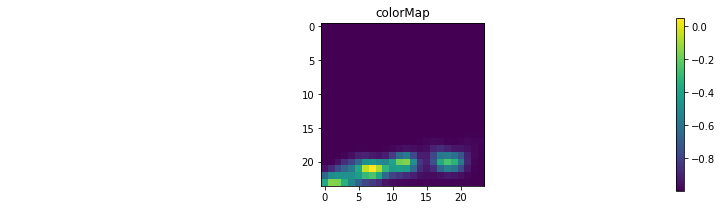

In [132]:
print(encoder.classes_)
image=generate_images(G,10,12)
H = image[0].reshape((24,24))

fig = plt.figure(figsize=(14, 3))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

여기서부터 Simple RNN을 구현합니다.

In [ ]:
RNNx_train=[]
RNNy_train=[]
RNNx_test=[]
RNNy_test=[]
RNN_kfoldx=[]
RNN_kfoldy=[]
for i in range(len(bar_matrix_list3)):
  nowseq=[]
  nowmat=np.array(bar_matrix_list3[i])
  nowbars=classifier.predict(nowmat.reshape(len(nowmat),24,24,1) ) #이는 mlb를 통해 embedding 되어있다
  for j,bars in enumerate(nowbars):
    if(j==len(nowbars)-1):
      if(i>5000):
        RNNy_test.append(np.argmax(bars))
      else:
        RNNy_train.append(np.argmax(bars))
      RNN_kfoldy.append(np.argmax(bars))
    else:
      nowseq.append(np.argmax(bars))
  if(i>5000):
    RNNx_test.append(nowseq)
  else:
    RNNx_train.append(nowseq)
  RNN_kfoldx.append(nowseq)

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
RNNy_test=to_categorical(np.array(RNNy_test))
RNNy_train=to_categorical(np.array(RNNy_train))
RNN_kfoldy=to_categorical(np.array(RNN_kfoldy))
# fix random seed for reproducibility
numpy.random.seed(7)
top_words=13
# truncate and pad input sequences
max_review_length =0
for seq in RNN_kfoldx:
  if (len(seq)>max_review_length):
    max_review_length=len(seq)
RNNx_train = sequence.pad_sequences(RNNx_train, maxlen=max_review_length)
RNNx_test = sequence.pad_sequences(RNNx_test, maxlen=max_review_length)
RNN_kfoldx = sequence.pad_sequences(RNN_kfoldx, maxlen=max_review_length)


In [ ]:
print(RNN_kfoldx.shape, RNN_kfoldy.shape)

(10000, 107) (10000, 13)


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model_path = '/content/drive/My Drive/models/' + 'RNN.h5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
callbacks = [cb_checkpoint]

In [ ]:
from keras import regularizers
# create the model
embedding_vecor_length = 32
timesteps = 8

RNNmodel = Sequential()
RNNmodel.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
RNNmodel.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, 100)))  # returns a sequence of vectors of dimension 32
RNNmodel.add(LSTM(100))  # return a single vector of dimension 32
RNNmodel.add(Dropout(0.2))
RNNmodel.add(Dense(13, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

RNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(RNNmodel.summary())



아래거는 kfold방식. 더 아래에는 그냥 위에서 설정한 RNNmodel을 train : valid = 1:1로 학습하는 코드가 있다.

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
for i in range(3):
  for train,valid in kfold.split(RNN_kfoldx,RNN_kfoldy):
    RNNmodel.fit(RNN_kfoldx[train],RNN_kfoldy[train], validation_data=(RNN_kfoldx[valid],RNN_kfoldy[valid]),epochs=30, batch_size=64,callbacks=callbacks)

In [ ]:
RNNmodel.load_weight('/content/drive/My Drive/models/RNN.h5')

In [ ]:
hist=RNNmodel.fit(RNNx_train, RNNy_train, validation_data=(RNNx_test, RNNy_test), epochs=300, batch_size=64,callbacks=callbacks)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
scores = model.evaluate(RNNx_test, RNNy_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 27.69%


In [ ]:
print(model.predict(RNNx_test))

[[0.00058642 0.00063235 0.00212106 ... 0.00035581 0.00314277 0.00107208]
 [0.00200537 0.00039899 0.01504618 ... 0.0016143  0.00947371 0.0021562 ]
 [0.00043494 0.00076485 0.00288963 ... 0.00060204 0.00506374 0.00097767]
 ...
 [0.00398669 0.00089505 0.00564978 ... 0.00082496 0.00648937 0.00188497]
 [0.00046164 0.00052354 0.00999689 ... 0.00185463 0.00193721 0.00123206]
 [0.00154445 0.0010455  0.00651681 ... 0.00544364 0.00606789 0.00185878]]


classifier : 24*24 bar input을 기반하여 Skill을 분류한다. 학습은 Multilabel Classifier로써 진행된다.

updown_classifier : 24*24 bar input을 기반하여 다음 bar의 pitch change를 분류한다. 학습은 up, down, final, meanless 4가지 기반하여 진행되나 분류 자체는 up, down만 유의미하다.

RNNmodel : bar skill sequence를 기반하여 다음 bar가 어떤 스킬을 가지는지를 분류한다. 학습은 k-fold기반의 RNN으로 진행된다

G : GAN기반한 모델의 Generator이다. image_generator(G,갯수,encoded skill num)과 같은 형태로 사용하여 이미지를 생성할 수 있다. 원할한 생성을 위해 Matrix Image에 Bluring을 사용한다.

이제 G가 생성한 Matrix이미지를 0과1로 이루어진 Matrix로 정리하고, Chord를 Match시켜준 뒤 MIDI로 Decoding하면 끝이다.

In [50]:
#Model Loading Only
RNNmodel = Sequential()
RNNmodel.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
RNNmodel.add(LSTM(100, return_sequences=True,
               input_shape=(timesteps, 100)))  # returns a sequence of vectors of dimension 32
RNNmodel.add(LSTM(100))  # return a single vector of dimension 32
RNNmodel.add(Dropout(0.2))
RNNmodel.add(Dense(13, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
RNNmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
RNNmodel.load_weight('/content/drive/My Drive/models/RNN.h5')

G = generator_model()
G.compile(loss='binary_crossentropy', optimizer=optimizer)
G.load_weights("/content/drive/My Drive/MARG/PPDDlist/GAN_result/generator.h5")

updown_classifier=make_classifier()
updown_classifier.compile(loss=keras.losses.CategoricalCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='categorical_crossentropy'
  ), optimizer='adam', metrics=['accuracy'])
updown_classifier.load_weights("/content/drive/My Drive/models/updown.h5")

classifier=make_model()
classifier.compile(loss=keras.losses.BinaryCrossentropy(
      from_logits=False, label_smoothing=0.1, 
      name='binary_crossentropy'
  ), optimizer='adam', metrics=['accuracy',recall,precision,f1score])
classifier.load_weights("/content/drive/My Drive/models/deeperppddbest.h5")

NameError: ignored

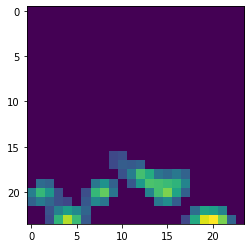

In [243]:
import cv2
H=generate_images(G,4,4)[0]
def matrix_cleaner(matrix):
  #matrix should be size of 24*24
  #make matrix's value of [0,1]  
  matrix=np.matrix(matrix)
  maximum_value=matrix.max()
  minimum_value=matrix.min()
  matrix=(matrix-minimum_value)/(maximum_value-minimum_value)
  flat=matrix.flatten()
  flat.sort()
  flat=flat.reshape((576,1))
  hundred_val=flat[-70]
  matrix=np.where(matrix<hundred_val,0,matrix)
  matrix=np.where(matrix<0.3,0,matrix)
  return matrix
plt.imshow(matrix_cleaner(H))

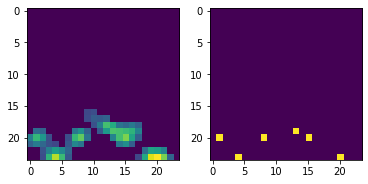

In [245]:
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp

#getting a list of images

paws = [matrix_cleaner(H)]


def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background
    detected_peaks=np.where(detected_peaks==True,1,0)

    return detected_peaks


#applying the detection and plotting results
for i, paw in enumerate(paws):
    detected_peaks = detect_peaks(paw)
    pp.subplot(1,2,(2*i+1))
    pp.imshow(paw)
    pp.subplot(1,2,(2*i+2) )
    pp.imshow(detected_peaks)

pp.show()

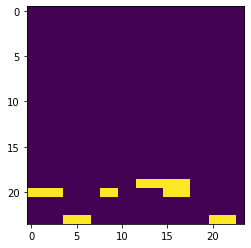

In [249]:
def left_shifting(matrix,detected_peak):
  #input은 detected_peak가 들어와야한다.
  dots=[]
  for j in range(len(detected_peak)):
    pos=[]
    for i in range(len(detected_peak[0])):#for 문의 순서를 이렇게 지정해야 Handle이 가능하다.
      if(detected_peak[i][j]==1):
        if(j%2!=0 and j%3!=0):
          j=j-1
        if(len(pos)==0):
          pos=[i,j]
        else:
          if (matrix[pos[0]][pos[1]]<matrix[i][j]):
            pos=[i,j]
    if(len(pos)!=0):
      dots.append(pos)
  dots_with_length=[]
  for position in dots:
    length_val=0
    while True:
      if(position[1]+length_val>23):
        break
      elif(matrix[position[0]][position[1]+length_val]!=0):
        dots_with_length.append([position[0],position[1]+length_val])
      else:
        break
      length_val+=1
  result=np.zeros_like(matrix)
  for position in dots_with_length:
    result[position[0]][position[1]]=1
  return result

plt.imshow(left_shifting(matrix_cleaner(H),detected_peaks))